# Final project for Artificial Intelligence and Machine Learning Course at Univeristy of Chicago

Goal of our project is to predict future REIT performance through stock data, real estate data and news article sentiment analysis. For the scope of this analysis, we will focus on the office sector within REITs as a way of narrowing our scope. 

By Cameron Keith and Jonathan Ling (August 2023)

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

In [48]:
# Read in Green Street data
df = pd.read_excel('Green Street REIT Data.xlsx')
print(df.shape)
df.head()

(29774, 227)


,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_auto_exemption_points,cg_wme_veto_points,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score
0,1988-10-24,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-10-24,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-10-24,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-10-24,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1988-10-24,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], format='%b-%y').dt.to_period('M')
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month # our data is monthly frequency

In [93]:
df.head()

,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score,year,month
0,1988-10,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
1,1988-10,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
2,1988-10,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
3,1988-10,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
4,1988-10,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10


In [132]:
# Let's drop descriptive features that won't help our model
drop_list = ['comp_id','sector_id','sector_pm1_id','date_bom','date_bs',
             'date_eom','date_last_published','date_mrpo','date_price','ticker_bb',
             'currency_symbol','sector_abbr','sector_pm1','sector_rt','initial1','initial2']

df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(drop_list, axis=1)

In [133]:
# Since we have a very wide dataset, we are going to focus on some features that
# should impact the sector/performance (utilizing Jonathan's industry knowledge)

testing_vars = ['date','year','month','symbol','price','dividend_yield','cash','nav_premium',
                'noi','capex_reserve', 'caprate_nominal_implied','shares']

df_testing = df_cleaned.loc[df_cleaned['sector'] == 'Office'] # focus on office sector
df_testing = df_testing[testing_vars]
df_testing.head()

,date,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,shares
1352,1993-01,1993,1,RCP,8.38,NaN,NaN,-0.301667,NaN,NaN,NaN,37510.0
1370,1993-02,1993,2,CRE,24.25,NaN,NaN,0.154762,NaN,NaN,NaN,13087.0
1388,1993-02,1993,2,RCP,9.50,NaN,NaN,-0.208333,NaN,NaN,NaN,37510.0
1406,1993-03,1993,3,CRE,26.00,0.065,NaN,0.106383,NaN,NaN,NaN,13232.0
1424,1993-03,1993,3,RCP,9.13,0.110,NaN,-0.239167,NaN,NaN,NaN,37510.0


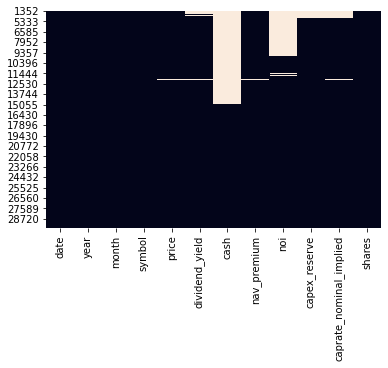

In [134]:
# Visualize where null values exist in our dataset
sns.heatmap(df_testing.isnull(), cbar=False)
plt.show()

Our dataset is pretty good, but cash and noi are two fields that have mor missing values. We will need to analyse to see why these are missing (panel nonresponse/time series gaps).

In [154]:
# Edits to dataframe for our analysis
df_office = df_testing.copy()
df_office = df_office.set_index('date')

# Transformations
df_office['price_pct'] = df_office.price.groupby(df_office['symbol']).pct_change()
df_office['cash_log'] = df_office.cash.groupby(df_office['symbol']).diff()
df_office['noi_dif'] = df_office.noi.groupby(df_office['symbol']).diff()
df_office['marketcap'] = df_office['price']*df_office['shares']

df_office = df_office.loc[df_office['year'] >= 2012] #filter past 2012, to match sentiment data
df_office.head()

,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,shares,price_pct,cash_log,noi_dif,marketcap
date,,,,,,,,,,,,,,,
2012-01,2012,1,BXP,101.32,0.021713,1099783.0,0.066526,1.170438e+06,0.138359,0.049141,168267.0,0.082826,0.0,-0.013053,17048812.44
2012-01,2012,1,CUZ,6.59,0.027314,5634.0,-0.287568,1.041740e+05,0.230453,0.082955,103714.0,0.126496,0.0,0.000000,683475.26
2012-01,2012,1,HIW,29.95,0.056761,34318.0,-0.018033,3.324460e+05,0.191745,0.076494,76489.0,0.045375,0.0,0.000000,2290845.55
2012-01,2012,1,KRC,38.24,0.036611,78481.0,-0.055802,2.556130e+05,0.242399,0.060753,61017.0,0.076880,0.0,0.000000,2333290.08
2012-01,2012,1,WRE,27.78,0.062455,40751.0,-0.111040,1.897160e+05,0.155351,0.066846,66066.0,0.036567,0.0,0.000000,1835313.48


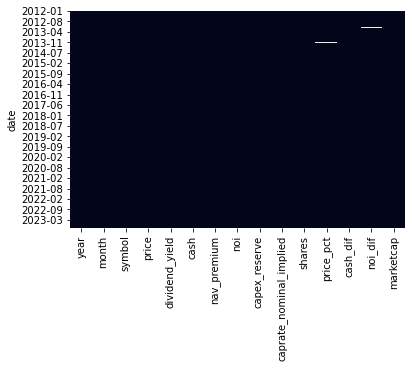

In [137]:
# View nulls
sns.heatmap(df_office.isnull(), cbar=False)
plt.show()

As we can see now, nealry all of our null values were from earlier dates. With our filter after 2012 (to match our sentiment data) we have a complete dataset. We can safely drop the small amount of missing data. 

In [147]:
df_office = df_office.dropna()

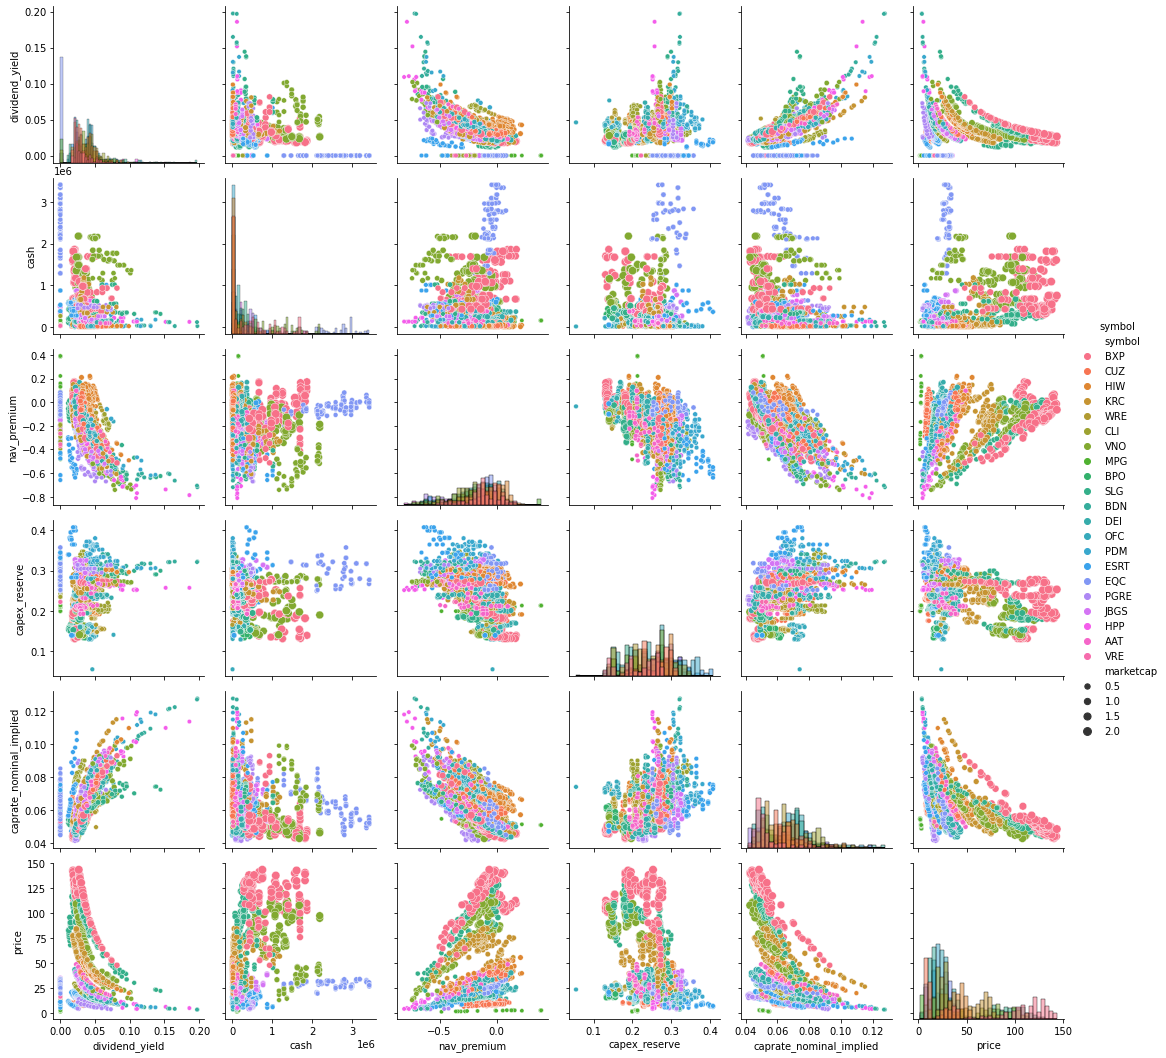

In [184]:
# Chart to analyze feature relationships
feature_list = ['symbol','dividend_yield','cash','nav_premium','capex_reserve','caprate_nominal_implied','price']
ax = sns.PairGrid(df_office.filter(items=feature_list), hue='symbol')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot, size=df_office['marketcap'])
ax.add_legend()

In [185]:
# We have a large outlier (CUZ) due to a reverse stock split, which distorts our price. 
# As a simple fix, we will drop this REIT from our analysis.
df_office = df_office.loc[df_office['symbol'] != 'CUZ'] # focus on office sector


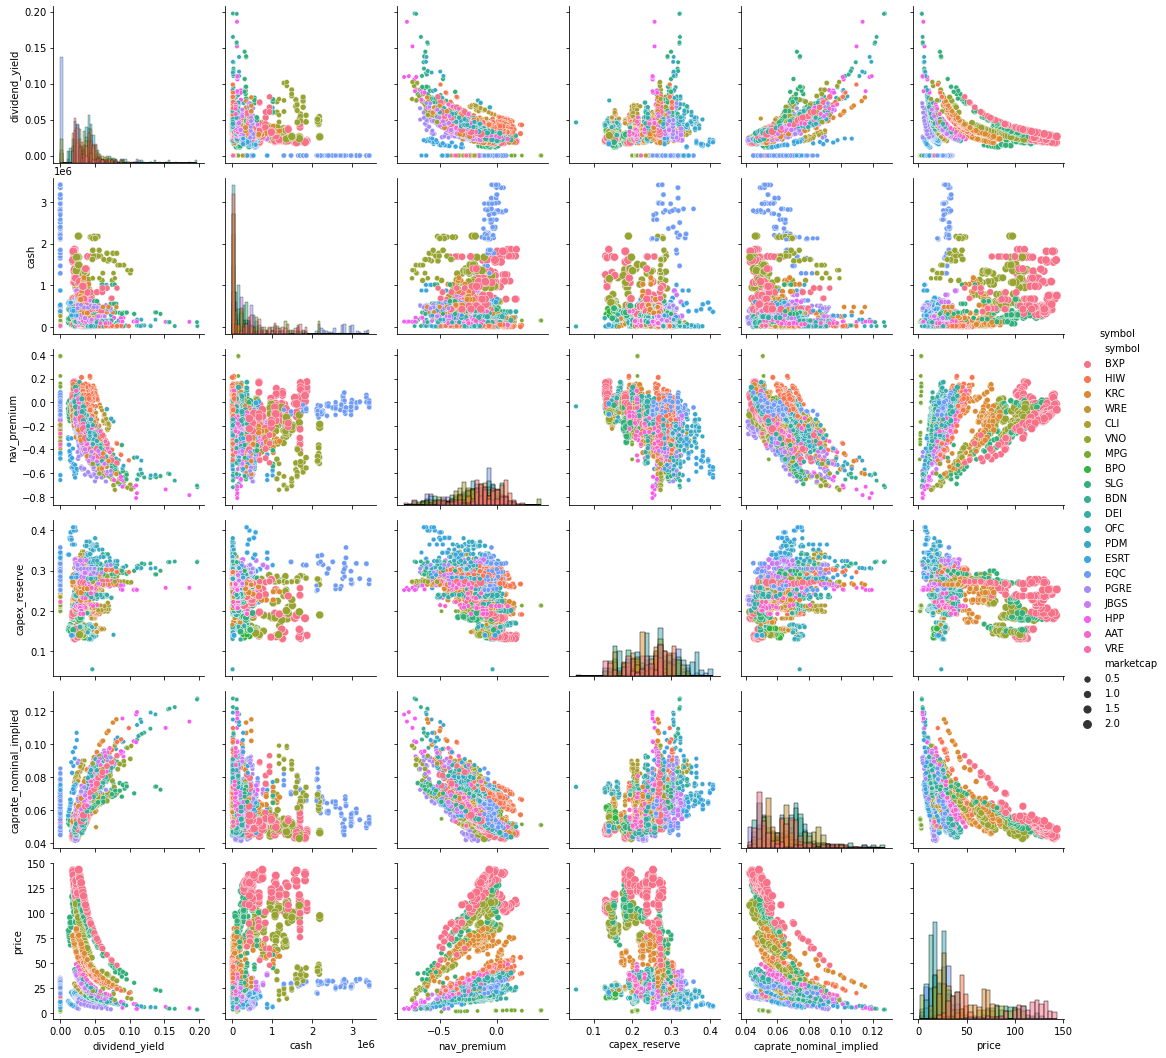

In [186]:
feature_list = ['symbol','dividend_yield','cash','nav_premium','capex_reserve','caprate_nominal_implied','price']
ax = sns.PairGrid(df_office.filter(items=feature_list), hue='symbol')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot, size=df_office['marketcap'])
ax.add_legend()

In [ ]:
# Merge dataset with sentiment analysis

In [187]:
# Create train/test datasets
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.2, n_splits=2, random_state = 0)
split = splitter.split(df_office, groups=df_office['symbol'])
train_inds, test_inds = next(split)

train = df_office.iloc[train_inds]
test = df_office.iloc[test_inds]

# Show the Training and Testing Data
print('Shape of training feature:', train.shape)
print('Shape of testing feature:', test.shape)

Shape of training feature: (1647, 15)
Shape of testing feature: (399, 15)


In [188]:
# Begin panel regression
from statsmodels.tsa.arima.model import ARIMA as ARIMA
from patsy import dmatrices
from statsmodels.regression import linear_model

expr = 'price ~ nav_premium + dividend_yield + caprate_nominal_implied'

y_train, x_train = dmatrices(expr, train, return_type='dataframe')
y_test, x_test = dmatrices(expr, test, return_type='dataframe')

olsr_results = linear_model.OLS(y_train, x_train).fit()
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     175.3
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.41e-98
Time:                        12:15:50   Log-Likelihood:                -7910.2
No. Observations:                1647   AIC:                         1.583e+04
Df Residuals:                    1643   BIC:                         1.585e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 122.2676      3.786     32.297      0.000     114.842     129.693
nav_premium                 3.2781      5.308      0.618      0.537      -7.132      13.689
dividend_yield            329.7785     49.717      6.633      0.000     232.264     427.293
caprate_nominal_implied -1425.7653     73.263    -19.461      0.000   -1569.464   -1282.066
==============================================================================
Omnibus:                       92.646   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.802
Skew:                           0.575   Prob(JB):                     2.13e-22
Kurtosis:                       2.639   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

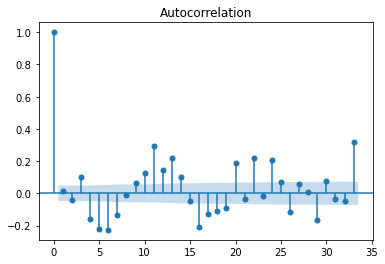

In [189]:
# Plot autocorrelation for residual error
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(olsr_results.resid, alpha=0.05)
plt.show()

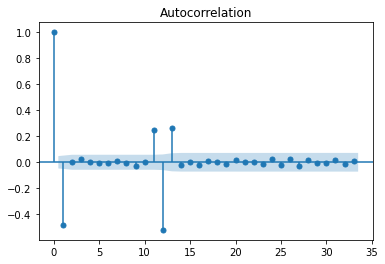

In [190]:
olsr_resid_diff_2 = olsr_resid_diff_1.diff()
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()
tsa.plot_acf(olsr_resid_diff_2, alpha=0.05)
plt.show()

In [195]:
x_train_minus_intercept = x_train.drop('Intercept', axis=1)
x_train_minus_intercept = x_train_minus_intercept.asfreq('M')
 
y_train = y_train.asfreq('M')

sarimax_model = ARIMA(endog=y_train, exog=x_train_minus_intercept,order=(1,1,0))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1647
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -8241.359
Date:                Sun, 20 Aug 2023   AIC                          16492.718
Time:                        12:21:13   BIC                          16519.749
Sample:                    01-31-2012   HQIC                         16502.741
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
nav_premium                25.8687      6.721      3.849      0.000      12.695      39.042
dividend_yield            374.2139     52.567      7.119      0.000     271.185     477.243
caprate_nominal_implied -1684.3572     90.524    -18.607      0.000   -1861.781   -1506.933
ar.L1                      -0.5129      0.026    -19.705      0.000      -0.564      -0.462
sigma2                   1307.3434     42.205     30.976      0.000    1224.623    1390.064
===================================================================================
Ljung-Box (L1) (Q):                  61.64   Jarque-Bera (JB):                34.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [196]:
x_test_minus_intercept = x_test.drop('Intercept', axis=1)
x_test_minus_intercept = x_test_minus_intercept.asfreq('M')
y_test = y_test.asfreq('M')

predictions = sarimax_results.get_forecast(steps=24, exog=x_test_minus_intercept[:24])
predictions.summary_frame()

price,mean,mean_se,mean_ci_lower,mean_ci_upper
2149-04,48.328756,36.157204,-22.538061,119.195573
2149-05,64.772413,40.218198,-14.053807,143.598634
2149-06,38.291639,48.509913,-56.786043,133.369320
2149-07,56.583507,53.367026,-48.013942,161.180956
2149-08,70.759519,58.825781,-44.536893,186.055932
2149-09,42.330642,63.332602,-81.798976,166.460261
2149-10,52.582930,67.770908,-80.245609,185.411468
2149-11,68.874185,71.823356,-71.897007,209.645377
2149-12,41.345721,75.713692,-107.050388,189.741830
2150-01,55.843793,79.386915,-99.751703,211.439288


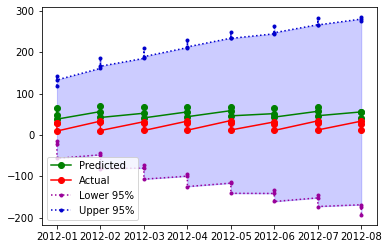

In [203]:
# Plot results
predicted, = plt.plot(x_test_minus_intercept[:24].index.astype('string'), predictions.summary_frame()['mean'], 'go-', label='Predicted')
 
actual, = plt.plot(x_test_minus_intercept[:24].index.astype('string'), y_test[:24], 'ro-', label='Actual')
 
lower, = plt.plot(x_test_minus_intercept[:24].index.astype('string'), predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(x_test_minus_intercept[:24].index.astype('string'), predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(x_test_minus_intercept[:24].index.astype('string'), predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
 
plt.legend(handles=[predicted, actual, lower, upper])
 
plt.show()